In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from matplotlib import pyplot as plt
import cv2
import json
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import pandas as pd
from collections import OrderedDict
from ensemble_boxes import *

In [2]:
carpart_config = '../checkpoints/12_10/carpart/swa_carpart.py'
carpart_checkpoint = '../checkpoints/12_10/carpart/swa_carpart.pth'
carpart_model = init_detector(carpart_config, carpart_checkpoint, device='cuda:0')

/mmdetection/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader


In [3]:
scratch_config = '../checkpoints/12_10/scratch/swa_scratch_pseudo.py'
scratch_checkpoint = '../checkpoints/12_10/scratch/swa_scratch_12_10.pth'
scratch_model = init_detector(scratch_config, scratch_checkpoint, device='cuda:0')

Use load_from_local loader


In [4]:
crack_config = '../checkpoints/combine_crack_phase_1/combine_crack.py'
crack_checkpoint = '../checkpoints/combine_crack_phase_1/epoch_28.pth'
crack_model = init_detector(crack_config, crack_checkpoint, device='cuda:0')

Use load_from_local loader


In [5]:
glass_broken_config = '../checkpoints/windshield/windshield.py'
glass_broken_checkpoint = '../checkpoints/windshield/swa_model_11.pth'
glass_broken_model = init_detector(glass_broken_config, glass_broken_checkpoint, device='cuda:0')

Use load_from_local loader


In [ ]:
#data = Path('/mmdetection/data/cracked_windshield_flickr')
#files = [str(i) for i in data.iterdir() if i.is_file()]
#print(files)
path = Path('/mmdetection/data/windshield/glass_broken')
data = json.load(open(path/'annotations'/'test.json'))
total = json.load(open(path/'annotations'/'total.json'))
print(len(total['annotations']))

In [6]:
carpart_labels = carpart_model.CLASSES
np.random.seed(42)
mask_colors = [
    np.random.randint(0, 256, (1, 3), dtype=np.uint8)
    for _ in range((len(carpart_labels)))
]

def plot_windshield(image,segms,labels):
    for idx,s in enumerate(segms):
        color = mask_colors[labels[idx]]
        color = color.tolist()
        #score = round(scores[idx],2)
        #print(color)
        #print(s)
        
        contours, _ = cv2.findContours(np.array(s).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #c = []
        if len(contours) == 0:
            continue
            
        c = max(contours,key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] != 0:
            cy = int(M["m01"] / M["m00"])
        else:
            cy = c[0][0][1]
            
        cx = [idi for idi,i in enumerate(s[cy]) if i][0]        
        
        image = cv2.drawContours(image,contours,-1,list(color[0]),2)
        #image = cv2.putText(image,carpart_labels[labels[idx]],(cx,cy),cv2.FONT_HERSHEY_SIMPLEX,1,list(color[0]),2,cv2.LINE_AA)
    
    return image

def plot_crack(image,segms,labels,scores):
    for idx,s in enumerate(segms):
        #color = 
        #color = mask_colors[labels[idx]]
        #color = color.tolist()
        score = round(scores[idx],2)
        #print(color)
        #print(s)
        
        contours, _ = cv2.findContours(np.array(s).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            continue
            
        c = max(contours,key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] != 0:
            cy = int(M["m01"] / M["m00"])
        else:
            cy = c[0][0][1]
            
        cx = [idi for idi,i in enumerate(s[cy]) if i][0]        
        
        image = cv2.drawContours(image,contours,-1,(255,0,255),2)
        image = cv2.putText(image,str(score)+'|crack |'+str(s.sum()),(cx+10,cy),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
    
    return image

In [7]:
def nms_float_fast(dets, thresh):
    """
    # It's different from original nms because we have float coordinates on range [0; 1]
    :param dets: numpy array of boxes with shape: (N, 5). Order: x1, y1, x2, y2, score. All variables in range [0; 1]
    :param thresh: IoU value for boxes
    :return: index of boxes to keep
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    
    scores = dets[:,4]
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        #print(i)
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
       
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= thresh)[0]
        #print(inds)
        #print(order)
        order = order[inds + 1]

    return keep

def check_windshield(segms,labels):
    ws = [(s,l) for idx,(s,l) in enumerate(zip(segms,labels)) if carpart_labels[l] == 'fwi_windshield']
    segms_out = [i[0] for i in ws]
    labels_out = [i[1] for i in ws]
    
    return segms_out,labels_out

#def carpart_inference(model,image,confident_score):
#    result = inference_detector(model,image.copy())
#    _,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model,image.copy(),result,score_thr=confident_score)
    
#    return pred_boxes,pred_segms,pred_labels,pred_scores

def damage_inference(image,confident_score):
    crack_result = inference_detector(crack_model,image.copy())
    scratch_result = inference_detector(scratch_model,image.copy())
    
    crack_result[0][0] = np.concatenate((crack_result[0][0],scratch_result[0][0]))
    crack_result[1][0].extend(scratch_result[1][0])
    #print('result :',crack_result[0][0])
    h,w = image.shape[:2]
    #print(h,w)
    boxes = crack_result[0][0]
    for idx,b in enumerate(boxes):
        boxes[idx][0] = boxes[idx][0] / w 
        boxes[idx][1] = boxes[idx][1] / h
        boxes[idx][2] = boxes[idx][2] / w
        boxes[idx][3] = boxes[idx][3] / h
    #print(boxes[:,4])
    #print(boxes)
    keep = nms_float_fast(boxes,0.4)
    #print(keep)
    crack_result[0][0] = boxes[keep]
    #print('segms :',crack_result[1][0])
    crack_result[1][0] = np.asarray(crack_result[1][0])[keep].tolist()
    
    out_image,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(crack_model,image.copy(),crack_result,score_thr=confident_score)
    
    return pred_boxes,pred_segms,pred_labels,pred_scores

def single_model_inference(model,image,confident_score):
    result = inference_detector(model,image.copy())
    out_image,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model,image.copy(),result,score_thr=confident_score)
    
    return pred_boxes,pred_segms,pred_labels,pred_scores

def damage_inference_v2(image,crack_confident,scratch_confident):    
    def filter_confident(det_result,confident):
        boxes = det_result[0][0]
        keep = np.where(boxes[:,4] >= confident)[0]
        det_result[0][0] = boxes[keep]
        det_result[1][0] = np.asarray(det_result[1][0])[keep].tolist()
        
        return det_result
    
    crack_result = inference_detector(crack_model,image.copy())
    crack_result = filter_confident(crack_result,crack_confident)
    
    scratch_result = inference_detector(scratch_model,image.copy())
    scratch_result = filter_confident(scratch_result,scratch_confident)
    
    crack_result[0][0] = np.concatenate((crack_result[0][0],scratch_result[0][0]))
    crack_result[1][0].extend(scratch_result[1][0])

    h,w = image.shape[:2]
    boxes = crack_result[0][0]
    
    for idx,b in enumerate(boxes):
        boxes[idx][0] = boxes[idx][0] / w 
        boxes[idx][1] = boxes[idx][1] / h
        boxes[idx][2] = boxes[idx][2] / w
        boxes[idx][3] = boxes[idx][3] / h

    keep = nms_float_fast(boxes,0.3)
    crack_result[0][0] = boxes[keep]
    crack_result[1][0] = np.asarray(crack_result[1][0])[keep].tolist()
    
    out_image,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(crack_model,image.copy(),crack_result,score_thr=0.01)
    
    if pred_segms is None:
        pred_segms = []
    return pred_boxes,pred_segms,pred_labels,pred_scores

def glass_broken_inference(image,confident):
    result = inference_detector(glass_broken_model,image.copy())
    _,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(glass_broken_model,image.copy(),result,score_thr=confident)
    
    if pred_segms is None :
        pred_segms = []
    
    return pred_boxes,pred_segms,pred_labels,pred_scores
    
def windshield_inference(image):
    ####### car part inference
    carpart_result = single_model_inference(carpart_model,image,0.7)
    #print(*carpart_result[1:3])
    windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
    
    ###### damge inference 
    #boxes,segms,labels,scores = damage_inference_v2(image.copy(),crack_confident=0.64,scratch_confident=0.62)
    boxes,segms,labels,scores = glass_broken_inference(image,confident=0.6)
    ###### post processing
    # check inside windshield
    
    if len(windshield_semgs) > 0 and len(segms) > 0:
        check = [False for _ in range(len(segms))]
        for idx,s in enumerate(segms): 
            if s.sum() == 0:
                continue
            intersect_check = [np.logical_and(s,ws).sum()/s.sum() > 0.7 for ws in windshield_semgs]
            #print(s.sum(),[np.logical_and(s,ws).sum()/s.sum() for ws in windshield_semgs])
            intersect_check = sum(intersect_check) > 0
            check[idx] = intersect_check

        boxes = np.array(boxes)[check]
        #print(len(segms),check)
        segms = segms[check]
        labels = labels[check]
        scores = scores[check]
        
    out = plot_windshield(image,windshield_semgs,windshield_labels)
    out = plot_crack(out,segms,labels,scores)
    
    return out

In [ ]:
'''
image = cv2.imread(files[145])

#damage_inference_v2(image,0.7,0.5)
plt.figure(figsize=(15,10))
show = cv2.cvtColor(np.hstack((image,windshield_inference(image.copy()))),cv2.COLOR_RGB2BGR)
plt.figure(figsize=(15,10))
plt.imshow(show)
'''
i = data['images'][0]
image = cv2.imread(str(path/'images'/i['file_name']))
annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id']==i['id']]
new_image = cv2.drawContours(image.copy(),annos,-1,(255,255,0))
plt.figure(figsize=(15,10))
plt.imshow(new_image)

In [ ]:
out_folder = 'windshield_test'
Path(out_folder).mkdir(parents=True,exist_ok=True)
for f in tqdm(data['images']):
    #print(idx)
    img = cv2.imread(str(path/'images'/f['file_name']))
    annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id']==f['id']]
    new_img = cv2.drawContours(img.copy(),annos,-1,(255,0,255))
    img = np.hstack((new_img,windshield_inference(img.copy())))
    cv2.imwrite(out_folder+'/'+f['file_name'],img)

In [ ]:
path = Path('/mmdetection/data/tmp/windshield/instagram')
files = [str(i) for i in path.iterdir() if i.is_file()]
print(files)


out_folder = 'windshield_instagram'
Path(out_folder).mkdir(parents=True,exist_ok=True)
for f in tqdm(files):
    #print(idx)
    img = cv2.imread(f)
    #annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id']==f['id']]
    #new_img = cv2.drawContours(img.copy(),annos,-1,(255,0,255))
    img = np.hstack((img,windshield_inference(img.copy())))
    cv2.imwrite(out_folder+'/'+f[f.rfind('/')+1:],img)

In [ ]:
s= '/mmdetection/data/tmp/windshield/instagram/119461813_3367613256685024_1741302932519352110_n.jpg'
s[s.rfind('/')+1:]

In [ ]:
# image file name need to be annotate
output = []
out_folder = 'windshield_anno'
Path(out_folder).mkdir(parents=True,exist_ok=True)

no_folder = 'windshield_no'
Path(no_folder).mkdir(parents=True,exist_ok=True)
for f in tqdm(files):
    #print(idx)
    img = cv2.imread(f)
    file_name = f[f.rfind('/')+1:]
    
    carpart_result = single_model_inference(carpart_model,img,0.9)
    windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
    
    boxes,segms,labels,scores = glass_broken_inference(img,confident=0.6)
    
    # model unable to detect any damages -> need to be annotate
    if len(segms) == 0:
        output.append(f)
        
        cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    # damage too large -> no
    areas_check = [s.sum() > 50116.5 for s in segms]
    if sum(areas_check) > 0:
        cv2.imwrite(no_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    # image from closed distance and it not bigger than 0.4 area of images
    if len(windshield_semgs) == 0:
        area = img.shape[0]*img.shape[1]
        ratios = [s.sum()/area > 0.4  for s in segms]
        check = sum(ratios) == 0
        if check :
            output.append(f)
            cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
            continue
    
    # if there is any damage in windshield and smaller than 0.1*area winshield -> need to be annotate
    main_ws = max(windshield_semgs,key=lambda p:p.sum())
    
    intersect_check = [np.logical_and(s,main_ws).sum() / s.sum() > 0.6 for s in segms if s.sum() > 0 and main_ws.sum() > 0]
    size_check = [np.logical_and(s,main_ws).sum() / main_ws.sum() > 0.6 for s in segms if s.sum() > 0 and main_ws.sum() > 0]
    
    # check nothing in main windshield -> potential FP windshield -> need annotation review
    if sum(intersect_check) == 0:
        cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    # check if damage too big -> no
    if np.logical_and(intersect_check,size_check).sum() > 0:
        cv2.imwrite(no_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))

In [ ]:
annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in total['annotations']]
areas = np.array([cv2.contourArea(a) for a in annos])
bound = 1
print(np.quantile(areas,bound))

a,b,c = plt.hist(areas[areas < np.quantile(areas,bound)],bins=100)

In [ ]:
f = '/mmdetection/data/tmp/windshield/instagram/117646015_3084515648441475_7781753156080295698_n.jpg'
image = cv2.imread(f)
#plt.imshow(image)
carpart_result = single_model_inference(carpart_model,image,0.7)
    #print(*carpart_result[1:3])
windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
plt.imshow(windshield_semgs[0])

In [ ]:
contours, _ = cv2.findContours(np.array(windshield_semgs[0]).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(image.copy(),contours,0,(255,255,0),2)
plt.imshow(img)

center :  [[1791 1173]]
angle :  103.99830686861276
angle :  138.79454906433207
prefix :  0.20199654912402676 [0.3  0.25] [0.4 0.5] 2.061116698631974
***adjust angle :  0.0 103.99830686861276 [1.81511287 2.42242186]
prefix :  0.754991372810067 [0.3  0.25] [0.4 0.5] 2.061116698631974
***adjust angle :  13.998306868612767 138.79454906433207 [1.81511287 2.42242186]


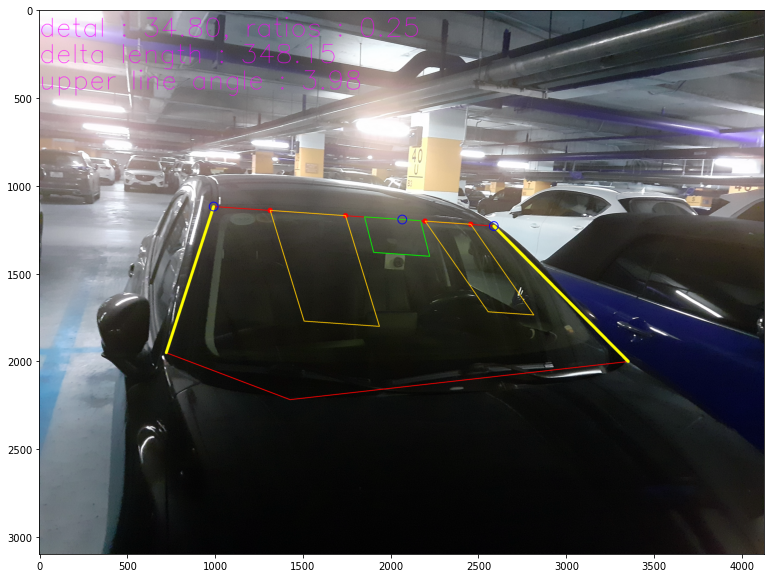

In [53]:
import math
from scipy import spatial

# find index of hightest corner of windshield
def high_of_point(point):
    return point[0][1]

# get upper line (index of highest point + its offset -> upper line)
#input : contour
#output : index + offset
def get_upper_line(cnt):
    len_cnt = len(cnt)
    highest_corner = min(cnt,key=high_of_point) 
    index = [idx for idx,p in enumerate(cnt) if (p == highest_corner).sum() == 2][0]

    p1 = cnt[(index+1)%len_cnt]
    p2 = cnt[(index-1)%len_cnt]

    norm_p1 = p1 - cnt[index]
    norm_p2 = p2 - cnt[index]

    tan_p1 = norm_p1[0][1] / norm_p1[0][0]
    tan_p2 = norm_p2[0][1] / norm_p2[0][0]

    ## upline is highest corner and its offset
    if abs(tan_p1) < abs(tan_p2):
        offset = 1
    else:
        offset = -1

    return index, offset

def get_angle(a,b,c):
    vector_ba = a-b 
    vector_bc = c-b

    cosin = 1 - spatial.distance.cosine(vector_ba,vector_bc)

    return math.acos(cosin)

def distance(p1,p2):
    vector_p = p2-p1

    return math.sqrt(np.power(vector_p,2).sum()) 

#intersect of two lines p1p2 and p3p4
#https://answers.opencv.org/question/9511/how-to-find-the-intersection-point-of-two-lines/
def cross_of_two_lines(p1,p2,p3,p4):
    #print('line 1 ',p1,p2)
    #print('line 2 ',p3,p4)
    x = p3-p1
    d1 = p2-p1
    d2 = p4-p3

    cross = d1[0][0]*d2[0][1] - d1[0][1]*d2[0][0]

    projection = (x[0][0]*d2[0][1]-x[0][1]*d2[0][0]) / cross

    intersect = (p1 + projection*d1).astype(np.int32)
    #print('cross : ',intersect)
    return intersect

# verify exception of upper line 
## angle > 150 :
#### side_len / upper_width > 0.3  -> remove point problem else add point problem
## agle > 140 and side_len / upper_width < alpha -> add point problem + alpha = ???
def verify_upper_line(cnt,index,offset):
    len_cnt = len(cnt)
    upper_width = distance(cnt[index],cnt[(index+offset)%len_cnt])
    new_cnt = cnt.copy()

    for zone_id in range(0,2):
        angle = get_angle(cnt[(index-offset+zone_id*offset)%len_cnt],cnt[(index+zone_id*offset)%len_cnt],
                          cnt[(index+offset+zone_id*offset)%len_cnt])
        #print('inside verify angle: ', angle/math.pi*180)

        side_point_id = (zone_id == 0)*(index-offset) + (zone_id == 1)*(index+2*offset)
        conern_id = (zone_id == 0)*(index) + (zone_id == 1)*(index+offset)

        side_height = distance(cnt[side_point_id%len_cnt],cnt[conern_id%len_cnt])

        ## ratio check 
        ratio = side_height/upper_width
        #print('ratio : ',side_height/upper_width)

        if angle/math.pi*180 > 150 :
            ## remove conern
            if ratio > 0.4:
                print('delete problem')
                new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)
            else:    
                ## add point
                print('add problem')
                low_conern_id = (zone_id == 0)*(index-2*offset) + (zone_id == 1)*(index+3*offset)
                new_point = cross_of_two_lines(cnt[low_conern_id%len_cnt],cnt[side_point_id%len_cnt],cnt[index],
                                               cnt[(index+offset)%len_cnt])

                new_cnt[side_point_id%len_cnt] = new_point
                new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)

            return new_cnt,*get_upper_line(new_cnt)

        if angle/math.pi*180 > 144 and ratio < 0.4:
            print('add problem')
            low_conern_id = (zone_id == 0)*(index-2*offset) + (zone_id == 1)*(index+3*offset)
            new_point = cross_of_two_lines(cnt[low_conern_id%len_cnt],cnt[side_point_id%len_cnt],cnt[index],
                                           cnt[(index+offset)%len_cnt])

            new_cnt[side_point_id%len_cnt] = new_point
            new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)

            return new_cnt,*get_upper_line(new_cnt)
        #side_point = cnt[side_point_id%len_cnt]

        #print('side point : ',side_point)

    return cnt,index,offset

## angle of vector1 and vector2 -> find vector2
def find_vector_from_angle(vector1,angle,vector_check):
    theta = np.power(vector1,2).sum() * math.cos(angle)**2
    a = vector1[0][0]**2 - theta
    b = 2*vector1[0][0]*vector1[0][1]
    c = vector1[0][1]**2 - theta

    result = np.roots([a,b,c])

    new_vec1 = np.array([[result[0],1]])
    check1 = abs(1 - spatial.distance.cosine(vector_check,new_vec1))
    new_vec2 = np.array([[result[1],1]])
    check2 = abs(1 - spatial.distance.cosine(vector_check,new_vec2))

    #print(check1,check2)

    if check1 > check2 :
        return new_vec1
    else:
        return new_vec2
    
### find magnitude of adjust_vector to rotate main_vector angle
def find_adjust_magnitude(adjust_vector,main_vector,adjsut_angle):
    # scalar of adjust_vector and main_vector
    x = (adjust_vector*main_vector).sum()

    # power 2 of length adjust_vector
    y = np.power(adjust_vector,2).sum()

    # power 2 of length main_vector
    z = np.power(main_vector,2).sum()

    ## quadratic
    a = x**2- math.cos(adjsut_angle)*y*z
    b = 2*x*z-2*math.cos(adjsut_angle)*x*z
    c = z**2 - math.cos(adjsut_angle)*z**2

    result = np.roots([a,b,c])

    #print(result)

    if sum(result > 0) == 1:
        return result[result>0][0]
    else:
        return min(result)

## input image, contour, start point, projection vector
## ouput height of windshield at start point
def find_windshield_height_at_point(img,cnt,point,projection):
    mask = np.zeros_like(img[:,:,0])
    i_vector = projection / math.sqrt(np.power(projection,2).sum())

    contour_mask = cv2.drawContours(mask.copy(),[cnt],-1,1,4)
    line_mask = cv2.line(mask.copy(),(point+10*i_vector).astype(np.int32)[0],
                         (point+max(img.shape[:2])*i_vector).astype(np.int32)[0],1,1)

    intersect = np.logical_and(contour_mask,line_mask)
    max_index = np.argmax(intersect)
    intersect_point = np.array([[int(max_index%mask.shape[1]),int(max_index/mask.shape[1])]])

    ws_height = distance(point,intersect_point)
    return ws_height
    
def driver_zone(image,ws_cnt):
    # simplify the contour
    peri = cv2.arcLength(ws_cnt, True)
    approx = cv2.approxPolyDP(ws_cnt, 0.02 * peri, True)
    LEN_APP = len(approx)
    
    # find upper line and verify
    index, offset = get_upper_line(approx)
    approx,index,offset = verify_upper_line(approx,index,offset)
    LEN_APP = len(approx)
    
    # draw verified contour 
    draw_image = cv2.drawContours(image.copy(),[approx],-1,(255,0,0),3)

    ## find center upper line according to pixel wise
    center = ((approx[index] + approx[(index+offset)%LEN_APP]) / 2).astype(np.int32)
    print('center : ',center)
    #draw_image = cv2.circle(draw_image,center[0],radius=25, color=(255, 255, 0), thickness=-1)
    
    ## vector of upper line
    vector = approx[(index+offset)%LEN_APP]-approx[index]
    length_vector = math.sqrt(np.power(vector,2).sum()) # uper line width
    
    # vector of 2 side lines in windshield
    side_vectors = [approx[index] - approx[(index-offset)%LEN_APP],approx[(index+offset)%LEN_APP] - approx[(index+2*offset)%LEN_APP]]
    
    draw_image = cv2.line(draw_image,approx[index][0],approx[(index-offset)%LEN_APP][0],(255,255,0),15)
    draw_image = cv2.line(draw_image,approx[(index+offset)%LEN_APP][0],approx[(index+2*offset)%LEN_APP][0],(255,255,0),15)
    
    # angles of 2 upper conern in windshield
    angles = []
    for zone_id in range(0,2):
        angle = get_angle(approx[(index-offset+zone_id*offset)%LEN_APP],approx[(index+zone_id*offset)%LEN_APP],
                          approx[(index+offset+zone_id*offset)%LEN_APP])
            
        angles.append(angle)
        #draw_image = cv2.putText(draw_image,str(angle/math.pi*180),(0,150*(zone_id+1)),cv2.FONT_HERSHEY_SIMPLEX,5,
        #                         (255,0,255),2, cv2.LINE_AA)
        print('angle : ', angle/math.pi*180)
    
    # recenter base on user's camera angle
    angles = np.array(angles)
    delta = abs(angles[0] - angles[1])
    camera_angle = math.pi/2 - delta
    delta_length = length_vector*(1/math.sin(camera_angle) - 1)
    adjust_center_vector = vector*((1-angles[0]/angles[1] > 0)*1 - (1-angles[0]/angles[1] <= 0))
    adjust_ratio = 0.8 
    
    if delta/math.pi*180 > 40:
        adjust_ratio = 0.5
    elif delta/math.pi*180 < 20:
        adjust_ratio = 1
        
    new_center = (center + adjust_ratio*adjust_center_vector/length_vector*delta_length).astype(np.int32)
    #print('new center : ',new_center,adjust_center_vector/length_vector*delta_length)
    
    ## center folowing bigger angles
    arg_max_angle = np.argmax(angles)
    center_angle = angles[arg_max_angle]
    #center_vector = side_vectors[arg_max_angle]
    center_vector = find_vector_from_angle(vector,center_angle,side_vectors[arg_max_angle])
    ws_height = find_windshield_height_at_point(image,approx,new_center,center_vector)
    under_center = new_center + 0.25*ws_height*center_vector/math.sqrt(np.power(center_vector,2).sum())
    under_center = under_center.astype(np.int32)
    #print('under center : ',under_center)
    
    adjust_vector = approx[(index + (1-arg_max_angle)*offset)%LEN_APP] - new_center
    adjust_angle = center_angle - math.pi/2 - 0.2*delta
    #print('adjust angle center : ',adjust_angle/math.pi*180)
    magnetude = find_adjust_magnitude(adjust_vector,under_center-new_center,adjust_angle)
    new_v = under_center-new_center + magnetude*adjust_vector
    #new_under = new_center+new_v
    #new_under = new_under.astype(np.int32)
    
    l1 = distance(approx[index],new_center)
    c1 = (approx[index]+(1-0.2)*l1*vector/length_vector).astype(np.int32)
    c2 = (c1 + 0.2*vector).astype(np.int32)
    c3 = (c1 + new_v).astype(np.int32)
    c4 = (c2 + new_v).astype(np.int32)
    
    camera_area = np.array([c1,c2,c4,c3])
    
    draw_image= cv2.drawContours(draw_image,[camera_area],-1,(0,255,0),3)
    #draw_image = cv2.circle(draw_image,z1[0],radius=25, color=(0, 255, 0), thickness=-1)
    #draw_image = cv2.circle(draw_image,z2[0],radius=25, color=(0, 255, 0), thickness=-1)
    
    
    
    
    draw_image = cv2.circle(draw_image,new_center[0],radius=25, color=(0, 0, 255), thickness=4)
    draw_image = cv2.circle(draw_image,approx[index][0],radius=25, color=(0, 0, 255), thickness=4)
    draw_image = cv2.circle(draw_image,approx[(index+offset)%LEN_APP][0],radius=25, color=(0, 0, 255), thickness=4)
    draw_image = cv2.putText(draw_image,f'detal : {delta/math.pi*180:.2f}, ratios : {1-angles[0]/angles[1]:.2f}',(0,150),cv2.FONT_HERSHEY_SIMPLEX,5,
                             (255,0,255),2, cv2.LINE_AA)
    draw_image = cv2.putText(draw_image,f'delta length : {delta_length:.2f}',(0,150*2),cv2.FONT_HERSHEY_SIMPLEX,5,
                             (255,0,255),2, cv2.LINE_AA)
    draw_image = cv2.putText(draw_image,f'upper line angle : {math.atan(vector[0][1]/vector[0][0])/math.pi*180:.2f}',(0,150*3),cv2.FONT_HERSHEY_SIMPLEX,5,
                             (255,0,255),2, cv2.LINE_AA)
    
    #return draw_image, 0 
    pre_image = draw_image.copy()
    
    ## locate driver / passenger area
    x_ratio = distance(approx[index],new_center) / distance(new_center,approx[(index+offset)%LEN_APP])
    
    # ratio of start point area to its coresponding half
    d_start_ratio = np.array([0.25,0.25])
    
    # angles of areas
    d_angles = np.copy(angles)
    vector_check_angles = side_vectors
    d_ajust_angles = abs(np.array(angles) - math.pi/2 - delta)
    
    if delta/math.pi*180 > 30 : 
        d_start_ratio[np.argmin(angles)] *=1.2
        d_angles[np.argmin(angles)] = 0.8*d_angles[1-np.argmin(angles)]
        vector_check_angles[np.argmin(angles)] = side_vectors[1-np.argmin(angles)]
        d_ajust_angles[np.argmin(angles)] = 0
    # ratio of width area to its corresponding half (default both sides will be 0.5)
    width_ratio = 1-2*d_start_ratio
    
    # angles related
    
    for zone_id in range(0,2):     
        #print('width adjust ',width_ajust[zone_id])
        average_angle = angles[zone_id]
     
        check_vector = side_vectors[zone_id]
        # cos check_vector ,[[1,0]] = 0 -> use check_vector of other side
        cosin_check =  (check_vector*[[1,0]]).sum() / math.sqrt(np.power(check_vector,2).sum())
        #print('angle check :',d_angles[zone_id],vector_check_angles[zone_id])
        #print('cosin check : ',cosin_check)
        if abs(cosin_check) < 0.09:
            v1 = find_vector_from_angle(vector,0.9*d_angles[1-zone_id],vector_check_angles[1-zone_id])
        else:
            v1 = find_vector_from_angle(vector,d_angles[zone_id],vector_check_angles[zone_id])
        
        ## find height of windshield
        # find driver zone
        prefix_ratio = (zone_id==0)*d_start_ratio[zone_id]*x_ratio/(x_ratio+1)\
        +(zone_id==1)*(1-(d_start_ratio[zone_id]+width_ratio[zone_id])/(x_ratio+1))
                
        print('prefix : ',prefix_ratio,d_start_ratio,width_ratio,x_ratio)
        #projection = prefix_ratio * length_vector 
        z_point1 = (approx[index] + prefix_ratio*vector).astype(np.int32)
        w = (zone_id==0)*width_ratio[zone_id]*x_ratio/(x_ratio+1)+(zone_id==1)*width_ratio[zone_id]/(x_ratio+1)
        #w = w * width_ajust[zone_id]
        z_point2 = (approx[index] + (prefix_ratio+w)*vector).astype(np.int32)
        
        draw_image = cv2.circle(draw_image,z_point1[0],radius=15, color=(255, 0, 0), thickness=-1)
        draw_image = cv2.circle(draw_image,z_point2[0],radius=15, color=(255, 0, 0), thickness=-1)
        
        ws_height = find_windshield_height_at_point(image,approx,z_point1,v1)

        projection = (0.6*ws_height/(math.sqrt(np.power(v1,2).sum())))
        projection_vector = projection*v1
        
        ## draw pre adjustion image 
        #pre_point3 = np.array(z_point2+projection_vector).astype(np.int32)
        #pre_point4 = np.array(z_point1+projection_vector).astype(np.int32)
        
        #pre_zone = np.array([z_point1,z_point2,pre_point3,pre_point4])
        #pre_image = cv2.drawContours(pre_image,[pre_zone],-1,(255,255,0),3)
        
        ##? tune this vector : projection*v1 to center
        ## vector from z_point1 -> center
        adjust_vector = center - z_point1
        
        adjust_angle = d_ajust_angles[zone_id]
        print('***adjust angle : ',adjust_angle/math.pi*180,angles[zone_id]/math.pi*180,angles)
        
        #print('adjust angle : ',adjust_angle/math.pi*180)
        if abs(cosin_check) < 0.09:
            adjsut_magnitude = 0
        else:
            adjsut_magnitude = find_adjust_magnitude(adjust_vector,projection_vector,adjust_angle)
        projection_vector = projection_vector + adjsut_magnitude*adjust_vector
        leng_projection = math.sqrt(np.power(projection_vector,2).sum())
        
        ws_height = find_windshield_height_at_point(image,approx,z_point1,projection_vector)
        projection_vector = (0.6*ws_height/leng_projection) * projection_vector
        
        z_point3 = np.array(z_point2+projection_vector).astype(np.int32)
        z_point4 = np.array(z_point1+projection_vector).astype(np.int32)
        #print('check : ',distance(z_point1,z_point2),distance(z_point3,z_point4))
        zone = np.array([z_point1,z_point2,z_point3,z_point4])

        draw_image= cv2.drawContours(draw_image,[zone],-1,(255,200,0),3)

    return draw_image, pre_image

def driver_zone_detection(image):
    ## windshield detection
    carpart_result = single_model_inference(carpart_model,image,0.5)
    windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
    
    if len(windshield_semgs) == 0 :
        return image 
    
    ws_segm = max(windshield_semgs,key=lambda x : x.sum())
    contours, _ = cv2.findContours(np.array(ws_segm).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ws_contour = max(contours,key=cv2.contourArea)
    raw_cnt_image = cv2.drawContours(image.copy(),[ws_contour],-1,(255,0,0),3)
    
    ## detect driver zone
    output, pre_image = driver_zone(image,ws_contour)
    
    #result1 = np.hstack([image,raw_cnt_image])
    #result2 = np.hstack([pre_image,output])
    
    #return np.vstack([result1,result2])
    return output

#f = '/mmdetection/data/tmp/windshield/test_pipeline/38.jpg'
#f = '/mmdetection/data/tmp/windshield/real_data/20211102_201857.jpg'
#20211102_202310.jpg
f = '/mmdetection/data/tmp/windshield/real_data/20211102_202310.jpg'
#20211102_202250.jpg
#f = '/mmdetection/data/tmp/windshield/real_data/20211102_202250.jpg'
image = cv2.imread(f)
out_image = driver_zone_detection(image)

plt.figure(figsize=(15,10))
plt.imshow(out_image)

In [ ]:
f = '/mmdetection/data/tmp/windshield/test_pipeline/67929713_1239811336196307_106183138884619112_n.jpg'
image = cv2.imread(f)
out_image = driver_zone_detection(image)
plt.figure(figsize=(15,10))
plt.imshow(out_image)

In [54]:
test_path = Path('/mmdetection/data/tmp/windshield/real_data')
files = [str(i) for i in test_path.iterdir() if i.is_file()]

out_folder = 'windshield_real_data_result'
Path(out_folder).mkdir(parents=True,exist_ok=True)

for f in tqdm(files):
    image = cv2.imread(f)
    print(f)
    out_image = driver_zone_detection(image)
    out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB)
    cv2.imwrite(out_folder+'/'+f[f.rfind('/')+1:],out_image)


  0%|                                                                                                                                                                           | 0/58 [00:00<?, ?it/s]

/mmdetection/data/tmp/windshield/real_data/20211102_202953.jpg
center :  [[1595 1370]]
angle :  118.54163066087636
angle :  123.59302609795539
prefix :  0.12597101704254487 [0.25 0.25] [0.5 0.5] 1.0156579054248625
***adjust angle :  23.490235223797367 118.54163066087636 [2.06894176 2.15710524]
prefix :  0.6279130511276345 [0.25 0.25] [0.5 0.5] 1.0156579054248625
***adjust angle :  28.54163066087638 123.59302609795539 [2.06894176 2.15710524]


  2%|██▊                                                                                                                                                                | 1/58 [00:02<02:07,  2.24s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202214.jpg
center :  [[2044 1232]]
angle :  128.76361747587512
angle :  125.16566108189876
prefix :  0.12467420858821952 [0.25 0.25] [0.5 0.5] 0.9948008880197687
***adjust angle :  35.16566108189877 128.76361747587512 [2.24734908 2.1845529 ]
prefix :  0.6240226257646586 [0.25 0.25] [0.5 0.5] 0.9948008880197687
***adjust angle :  31.567704687922426 125.16566108189876 [2.24734908 2.1845529 ]


  3%|█████▌                                                                                                                                                             | 2/58 [00:04<02:09,  2.31s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202549.jpg
center :  [[1659  987]]
angle :  110.62291379704963
angle :  144.1101971100002
prefix :  0.1975650534138673 [0.3  0.25] [0.4 0.5] 1.9286880112515534
***adjust angle :  0.0 110.62291379704963 [1.93073407 2.51519743]
prefix :  0.7439126335346684 [0.3  0.25] [0.4 0.5] 1.9286880112515534
***adjust angle :  20.622913797049645 144.1101971100002 [1.93073407 2.51519743]


  5%|████████▍                                                                                                                                                          | 3/58 [00:08<02:32,  2.77s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203449.jpg
center :  [[1482  870]]
angle :  119.61862333990314
angle :  138.97242057883514
prefix :  0.13988183059652365 [0.25 0.25] [0.5 0.5] 1.2702883761533696
***adjust angle :  10.264826100971158 119.61862333990314 [2.08773882 2.42552631]
prefix :  0.6696454917895709 [0.25 0.25] [0.5 0.5] 1.2702883761533696
***adjust angle :  29.61862333990315 138.97242057883514 [2.08773882 2.42552631]


  7%|███████████▏                                                                                                                                                       | 4/58 [00:11<02:28,  2.75s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202316.jpg
center :  [[1851 1355]]
angle :  117.26958335982937
angle :  127.49532059439198
prefix :  0.12902428384254577 [0.25 0.25] [0.5 0.5] 1.0665304404944875
***adjust angle :  17.043846125266757 117.26958335982937 [2.04674034 2.22521313]
prefix :  0.6370728515276373 [0.25 0.25] [0.5 0.5] 1.0665304404944875
***adjust angle :  27.26958335982937 127.49532059439198 [2.04674034 2.22521313]


  9%|██████████████                                                                                                                                                     | 5/58 [00:14<02:32,  2.88s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203139.jpg
center :  [[1903 1277]]
angle :  118.45256162869244
angle :  135.86454955900214
prefix :  0.1368352703046387 [0.25 0.25] [0.5 0.5] 1.2091688874528168
***adjust angle :  11.040573698382763 118.45256162869244 [2.06738721 2.37128373]
prefix :  0.6605058109139162 [0.25 0.25] [0.5 0.5] 1.2091688874528168
***adjust angle :  28.452561628692443 135.86454955900214 [2.06738721 2.37128373]


 10%|████████████████▊                                                                                                                                                  | 6/58 [00:17<02:36,  3.00s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_201925.jpg
delete problem
center :  [[1898 1124]]
angle :  113.00477611950778
angle :  127.06853587662941
prefix :  0.1326496086361542 [0.25 0.25] [0.5 0.5] 1.1303721026790021
***adjust angle :  8.941016362386167 113.00477611950778 [1.97230541 2.21776433]
prefix :  0.6479488259084626 [0.25 0.25] [0.5 0.5] 1.1303721026790021
***adjust angle :  23.00477611950779 127.06853587662941 [1.97230541 2.21776433]


 12%|███████████████████▋                                                                                                                                               | 7/58 [00:20<02:31,  2.98s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202522.jpg
center :  [[1346 1556]]
angle :  125.19688470647047
angle :  129.1236063134156
prefix :  0.12540754125012904 [0.25 0.25] [0.5 0.5] 1.006541989045215
***adjust angle :  31.270163099525355 125.19688470647047 [2.18509785 2.25363207]
prefix :  0.6262226237503871 [0.25 0.25] [0.5 0.5] 1.006541989045215
***adjust angle :  35.19688470647047 129.1236063134156 [2.18509785 2.25363207]


 14%|██████████████████████▍                                                                                                                                            | 8/58 [00:23<02:30,  3.00s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202740.jpg
center :  [[2502 1153]]
angle :  110.47629350261252
angle :  131.75324838798062
prefix :  0.13972615598094845 [0.25 0.25] [0.5 0.5] 1.2670833888479354
***adjust angle :  0.8006613827555776 110.47629350261252 [1.92817507 2.29952798]
prefix :  0.6691784679428454 [0.25 0.25] [0.5 0.5] 1.2670833888479354
***adjust angle :  20.476293502612517 131.75324838798062 [1.92817507 2.29952798]


 16%|█████████████████████████▎                                                                                                                                         | 9/58 [00:27<02:41,  3.29s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202909.jpg
center :  [[1997 1559]]
angle :  124.20183249861083
angle :  130.79384558824762
prefix :  0.126712213077052 [0.25 0.25] [0.5 0.5] 1.0277758749635448
***adjust angle :  27.609819408974026 124.20183249861083 [2.16773091 2.28278325]
prefix :  0.6301366392311559 [0.25 0.25] [0.5 0.5] 1.0277758749635448
***adjust angle :  34.20183249861083 130.79384558824762 [2.16773091 2.28278325]


 17%|███████████████████████████▉                                                                                                                                      | 10/58 [00:30<02:37,  3.28s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203052.jpg
center :  [[1421 2381]]
angle :  121.86053582683198
angle :  123.30929686724338
prefix :  0.125 [0.25 0.25] [0.5 0.5] 1.0
***adjust angle :  30.411774786420548 121.86053582683198 [2.12686758 2.15215323]
prefix :  0.625 [0.25 0.25] [0.5 0.5] 1.0
***adjust angle :  31.860535826831963 123.30929686724338 [2.12686758 2.15215323]


 19%|██████████████████████████████▋                                                                                                                                   | 11/58 [00:34<02:37,  3.35s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203301.jpg
add problem
center :  [[1921 1450]]
angle :  107.91419915560846
angle :  139.07535418672322
prefix :  0.19033203273281524 [0.3  0.25] [0.4 0.5] 1.7355298677972957
***adjust angle :  0.0 107.91419915560846 [1.88345808 2.42732284]
prefix :  0.7258300818320382 [0.3  0.25] [0.4 0.5] 1.7355298677972957
***adjust angle :  17.91419915560845 139.07535418672322 [1.88345808 2.42732284]


 21%|█████████████████████████████████▌                                                                                                                                | 12/58 [00:38<02:44,  3.58s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203312.jpg
add problem
center :  [[1485 2075]]
angle :  125.24483978104601
angle :  124.19839596867453
prefix :  0.12506490021409872 [0.25 0.25] [0.5 0.5] 1.0010389428464848
***adjust angle :  34.19839596867452 125.24483978104601 [2.18593483 2.16767094]
prefix :  0.6251947006422962 [0.25 0.25] [0.5 0.5] 1.0010389428464848
***adjust angle :  33.151952156303025 124.19839596867453 [2.18593483 2.16767094]


 22%|████████████████████████████████████▎                                                                                                                             | 13/58 [00:41<02:26,  3.25s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203221.jpg
add problem
center :  [[1371 2347]]
angle :  117.38760021593475
angle :  134.48397655183433
prefix :  0.13646111710541592 [0.25 0.25] [0.5 0.5] 1.2018888474718754
***adjust angle :  10.291223880035178 117.38760021593475 [2.04880012 2.34718818]
prefix :  0.6593833513162477 [0.25 0.25] [0.5 0.5] 1.2018888474718754
***adjust angle :  27.387600215934754 134.48397655183433 [2.04880012 2.34718818]


 24%|███████████████████████████████████████                                                                                                                           | 14/58 [00:44<02:20,  3.18s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202103.jpg
delete problem
center :  [[2078 1440]]
angle :  111.57938771746298
angle :  126.79190888341932
prefix :  0.13426821405544812 [0.25 0.25] [0.5 0.5] 1.16016713091922
***adjust angle :  6.36686655150664 111.57938771746298 [1.94742769 2.21293627]
prefix :  0.6528046421663443 [0.25 0.25] [0.5 0.5] 1.16016713091922
***adjust angle :  21.579387717462986 126.79190888341932 [1.94742769 2.21293627]


 26%|█████████████████████████████████████████▉                                                                                                                        | 15/58 [00:48<02:30,  3.50s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_201850.jpg
center :  [[1402  691]]
angle :  88.37088503342869
angle :  119.12131938985935
prefix :  0.18916972072104202 [0.3  0.25] [0.4 0.5] 1.7068415053336192
***adjust angle :  0.0 88.37088503342869 [1.54236291 2.07905923]
prefix :  0.722924301802605 [0.3  0.25] [0.4 0.5] 1.7068415053336192
***adjust angle :  1.6291149665713012 119.12131938985935 [1.54236291 2.07905923]


 28%|████████████████████████████████████████████▋                                                                                                                     | 16/58 [00:50<02:13,  3.17s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202620.jpg
center :  [[1662 1316]]
angle :  103.45602646431333
angle :  135.9060604376524
prefix :  0.19424827583641363 [0.3  0.25] [0.4 0.5] 1.836833180477822
***adjust angle :  0.0 103.45602646431333 [1.80564829 2.37200823]
prefix :  0.7356206895910341 [0.3  0.25] [0.4 0.5] 1.836833180477822
***adjust angle :  13.456026464313327 135.9060604376524 [1.80564829 2.37200823]


 29%|███████████████████████████████████████████████▍                                                                                                                  | 17/58 [00:54<02:17,  3.36s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202109.jpg
delete problem
center :  [[1849 1255]]
angle :  114.26539177119356
angle :  129.5170105215168
prefix :  0.13407610935817085 [0.25 0.25] [0.5 0.5] 1.156587383462023
***adjust angle :  9.013773020870298 114.26539177119356 [1.99430731 2.26049827]
prefix :  0.6522283280745126 [0.25 0.25] [0.5 0.5] 1.156587383462023
***adjust angle :  24.26539177119356 129.5170105215168 [1.99430731 2.26049827]


 31%|██████████████████████████████████████████████████▎                                                                                                               | 18/58 [00:57<02:04,  3.12s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202842.jpg
center :  [[2150 1349]]
angle :  110.43970878175232
angle :  140.42204835182844
prefix :  0.1560329424620378 [0.25 0.25] [0.5 0.5] 1.6605068472959406
***adjust angle :  9.54263078832382 110.43970878175232 [1.92753654 2.45082709]
prefix :  0.7180988273861135 [0.25 0.25] [0.5 0.5] 1.6605068472959406
***adjust angle :  20.439708781752316 140.42204835182844 [1.92753654 2.45082709]


 33%|█████████████████████████████████████████████████████                                                                                                             | 19/58 [01:00<02:03,  3.17s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202250.jpg
add problem
center :  [[1993  654]]
angle :  130.06377251698203
angle :  115.27186404681406
prefix :  0.11628145952638409 [0.25 0.25] [0.5 0.5] 0.8695986294385832
***adjust angle :  25.27186404681407 130.06377251698203 [2.27004107 2.01187356]
prefix :  0.5988443785791524 [0.25 0.25] [0.5 0.5] 0.8695986294385832
***adjust angle :  10.479955576646125 115.27186404681406 [2.27004107 2.01187356]


 34%|███████████████████████████████████████████████████████▊                                                                                                          | 20/58 [01:03<02:03,  3.26s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202510.jpg
center :  [[1364 1676]]
angle :  130.48445630150508
angle :  120.11402598170841
prefix :  0.12105807868621914 [0.25 0.25] [0.5 0.5] 0.9388574131110058
***adjust angle :  30.1140259817084 130.48445630150508 [2.27738339 2.09638523]
prefix :  0.6131742360586574 [0.25 0.25] [0.5 0.5] 0.9388574131110058
***adjust angle :  19.743595661911733 120.11402598170841 [2.27738339 2.09638523]


 36%|██████████████████████████████████████████████████████████▋                                                                                                       | 21/58 [01:07<02:05,  3.38s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203327.jpg
center :  [[1396 1563]]
angle :  116.8352180644751
angle :  134.49858867663573
prefix :  0.13734536774662126 [0.25 0.25] [0.5 0.5] 1.2191719505835232
***adjust angle :  9.171847452314458 116.8352180644751 [2.03915924 2.34744321]
prefix :  0.6620361032398638 [0.25 0.25] [0.5 0.5] 1.2191719505835232
***adjust angle :  26.835218064475093 134.49858867663573 [2.03915924 2.34744321]


 38%|█████████████████████████████████████████████████████████████▍                                                                                                    | 22/58 [01:10<02:02,  3.40s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203001.jpg
delete problem
center :  [[1714 1390]]
angle :  116.07341890785509
angle :  128.17821148078104
prefix :  0.13072567678282515 [0.25 0.25] [0.5 0.5] 1.096008539447335
***adjust angle :  13.968626334929159 116.07341890785509 [2.02586333 2.23713182]
prefix :  0.6421770303484755 [0.25 0.25] [0.5 0.5] 1.096008539447335
***adjust angle :  26.073418907855096 128.17821148078104 [2.02586333 2.23713182]


 40%|████████████████████████████████████████████████████████████████▏                                                                                                 | 23/58 [01:13<01:50,  3.17s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202240.jpg
center :  [[1872  738]]
angle :  125.54214324778472
angle :  132.22435337466896
prefix :  0.12676614827761434 [0.25 0.25] [0.5 0.5] 1.0286633624272825
***adjust angle :  28.85993312090049 125.54214324778472 [2.19112375 2.30775032]
prefix :  0.6302984448328431 [0.25 0.25] [0.5 0.5] 1.0286633624272825
***adjust angle :  35.54214324778473 132.22435337466896 [2.19112375 2.30775032]


 41%|███████████████████████████████████████████████████████████████████                                                                                               | 24/58 [01:16<01:49,  3.22s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202434.jpg
center :  [[1966 1215]]
angle :  127.69579310420401
angle :  130.24149191637443
prefix :  0.1251279343217113 [0.25 0.25] [0.5 0.5] 1.0020490462941631
***adjust angle :  35.150094292033586 127.69579310420401 [2.22871203 2.27314286]
prefix :  0.625383802965134 [0.25 0.25] [0.5 0.5] 1.0020490462941631
***adjust angle :  37.69579310420401 130.24149191637443 [2.22871203 2.27314286]


 43%|█████████████████████████████████████████████████████████████████████▊                                                                                            | 25/58 [01:19<01:40,  3.05s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202606.jpg
delete problem
center :  [[2334 1209]]
angle :  125.61158972161408
angle :  119.55283482699363
prefix :  0.1235355703507794 [0.25 0.25] [0.5 0.5] 0.9768404498674839
***adjust angle :  29.552834826993635 125.61158972161408 [2.19233582 2.0865906 ]
prefix :  0.6206067110523382 [0.25 0.25] [0.5 0.5] 0.9768404498674839
***adjust angle :  23.49407993237318 119.55283482699363 [2.19233582 2.0865906 ]


 45%|████████████████████████████████████████████████████████████████████████▌                                                                                         | 26/58 [01:22<01:36,  3.00s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202439.jpg
center :  [[2029 1168]]
angle :  118.98664875114136
angle :  132.58936171431566
prefix :  0.13233470483072352 [0.25 0.25] [0.5 0.5] 1.1246706570560439
***adjust angle :  15.38393578796705 118.98664875114136 [2.07670879 2.31412092]
prefix :  0.6470041144921705 [0.25 0.25] [0.5 0.5] 1.1246706570560439
***adjust angle :  28.986648751141352 132.58936171431566 [2.07670879 2.31412092]


 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                      | 27/58 [01:25<01:34,  3.06s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_201857.jpg
add problem
center :  [[2092 1271]]
angle :  127.86183173038927
angle :  126.8730399671648
prefix :  0.12506299516786584 [0.25 0.25] [0.5 0.5] 1.001008430896042
***adjust angle :  36.8730399671648 127.86183173038927 [2.23160995 2.21435228]
prefix :  0.6251889855035975 [0.25 0.25] [0.5 0.5] 1.001008430896042
***adjust angle :  35.88424820394033 126.8730399671648 [2.23160995 2.21435228]


 48%|██████████████████████████████████████████████████████████████████████████████▏                                                                                   | 28/58 [01:28<01:33,  3.12s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202839.jpg
add problem
center :  [[1704 1302]]
angle :  103.52800860267646
angle :  139.00269927458464
prefix :  0.2045718152125811 [0.3  0.25] [0.4 0.5] 2.1437253120584523
***adjust angle :  0.0 103.52800860267646 [1.80690462 2.42605477]
prefix :  0.7614295380314529 [0.3  0.25] [0.4 0.5] 2.1437253120584523
***adjust angle :  13.528008602676472 139.00269927458464 [1.80690462 2.42605477]


 50%|█████████████████████████████████████████████████████████████████████████████████                                                                                 | 29/58 [01:32<01:35,  3.28s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_201845.jpg
center :  [[2045 1085]]
angle :  121.26186042498324
angle :  122.09743733497442
prefix :  0.12494271694702815 [0.25 0.25] [0.5 0.5] 0.999083890972626
***adjust angle :  30.426283514992054 121.26186042498324 [2.11641872 2.13100229]
prefix :  0.6248281508410845 [0.25 0.25] [0.5 0.5] 0.999083890972626
***adjust angle :  31.261860424983237 122.09743733497442 [2.11641872 2.13100229]


 52%|███████████████████████████████████████████████████████████████████████████████████▊                                                                              | 30/58 [01:35<01:30,  3.24s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203402.jpg
center :  [[1750 1280]]
angle :  116.74608137563636
angle :  137.44865984751522
prefix :  0.13879840429396031 [0.25 0.25] [0.5 0.5] 1.2481691779034587
***adjust angle :  6.043502903757525 116.74608137563636 [2.03760351 2.39893167]
prefix :  0.6663952128818811 [0.25 0.25] [0.5 0.5] 1.2481691779034587
***adjust angle :  26.746081375636372 137.44865984751522 [2.03760351 2.39893167]


 53%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 31/58 [01:39<01:28,  3.27s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203129.jpg
add problem
center :  [[1928  944]]
angle :  104.83319920081998
angle :  132.51040649306123
prefix :  0.15077148483014174 [0.25 0.25] [0.5 0.5] 1.5194370748373371
***adjust angle :  12.844008091421264 104.83319920081998 [1.82968449 2.31274289]
prefix :  0.7023144544904252 [0.25 0.25] [0.5 0.5] 1.5194370748373371
***adjust angle :  14.833199200819978 132.51040649306123 [1.82968449 2.31274289]


 55%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 32/58 [01:43<01:33,  3.58s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202913.jpg
center :  [[2362 1345]]
angle :  95.07247571870461
angle :  140.89806735938754
prefix :  0.21525432846032524 [0.3  0.25] [0.4 0.5] 2.5400038084488035
***adjust angle :  0.0 95.07247571870461 [1.65932773 2.45913519]
prefix :  0.7881358211508132 [0.3  0.25] [0.4 0.5] 2.5400038084488035
***adjust angle :  5.072475718704603 140.89806735938754 [1.65932773 2.45913519]


 57%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 33/58 [01:47<01:33,  3.72s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202327.jpg
delete problem
center :  [[2148 1363]]
angle :  123.61236700352403
angle :  126.91470179717861
prefix :  0.12540431385346462 [0.25 0.25] [0.5 0.5] 1.0064900136749373
***adjust angle :  30.310032209869433 123.61236700352403 [2.1574428  2.21507942]
prefix :  0.6262129415603938 [0.25 0.25] [0.5 0.5] 1.0064900136749373
***adjust angle :  33.61236700352402 126.91470179717861 [2.1574428  2.21507942]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 34/58 [01:51<01:31,  3.80s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203037.jpg
center :  [[1825 1358]]
angle :  123.18570859515972
angle :  133.46312052452018
prefix :  0.1289836421275482 [0.25 0.25] [0.5 0.5] 1.0658364240600735
***adjust angle :  22.908296665799256 123.18570859515972 [2.14999621 2.32937088]
prefix :  0.6369509263826445 [0.25 0.25] [0.5 0.5] 1.0658364240600735
***adjust angle :  33.18570859515972 133.46312052452018 [2.14999621 2.32937088]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 35/58 [01:55<01:30,  3.94s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203423.jpg
center :  [[1495  759]]
angle :  94.1487463337171
angle :  136.55688345013758
prefix :  0.20304712604903566 [0.3  0.25] [0.4 0.5] 2.094286819715426
***adjust angle :  0.0 94.1487463337171 [1.64320561 2.38336723]
prefix :  0.7576178151225892 [0.3  0.25] [0.4 0.5] 2.094286819715426
***adjust angle :  4.148746333717105 136.55688345013758 [1.64320561 2.38336723]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 36/58 [01:57<01:14,  3.40s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203249.jpg
center :  [[2047 1593]]
angle :  122.96197615457196
angle :  129.83152876908804
prefix :  0.1267246873027677 [0.25 0.25] [0.5 0.5] 1.0279810655520882
***adjust angle :  26.092423540055886 122.96197615457196 [2.14609134 2.26598765]
prefix :  0.6301740619083032 [0.25 0.25] [0.5 0.5] 1.0279810655520882
***adjust angle :  32.961976154571964 129.83152876908804 [2.14609134 2.26598765]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 37/58 [02:00<01:08,  3.26s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202514.jpg
add problem
center :  [[1460 1179]]
angle :  130.61334334995666
angle :  125.89056701693747
prefix :  0.12398144508725752 [0.25 0.25] [0.5 0.5] 0.9838348422032336
***adjust angle :  35.89056701693748 130.61334334995666 [2.27963289 2.19720489]
prefix :  0.6219443352617726 [0.25 0.25] [0.5 0.5] 0.9838348422032336
***adjust angle :  31.167790683918295 125.89056701693747 [2.27963289 2.19720489]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 38/58 [02:03<01:01,  3.06s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202452.jpg
center :  [[1815 1839]]
angle :  96.69043016711045
angle :  129.88348599030627
prefix :  0.1969734327570229 [0.3  0.25] [0.4 0.5] 1.9118702877140634
***adjust angle :  0.0 96.69043016711045 [1.68756636 2.26689447]
prefix :  0.7424335818925574 [0.3  0.25] [0.4 0.5] 1.9118702877140634
***adjust angle :  6.690430167110463 129.88348599030627 [1.68756636 2.26689447]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 39/58 [02:06<01:01,  3.22s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203435.jpg
center :  [[2294 1228]]
angle :  108.5110959212518
angle :  138.68418517974297
prefix :  0.18772253345032217 [0.3  0.25] [0.4 0.5] 1.6719519884006582
***adjust angle :  0.0 108.5110959212518 [1.8938759  2.42049565]
prefix :  0.7193063336258054 [0.3  0.25] [0.4 0.5] 1.6719519884006582
***adjust angle :  18.511095921251783 138.68418517974297 [1.8938759  2.42049565]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 40/58 [02:09<00:52,  2.90s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202859.jpg
center :  [[2503 1420]]
angle :  142.36735806295025
angle :  105.15578468146244
prefix :  0.07375715629475672 [0.25 0.3 ] [0.5 0.4] 0.41849731168722865
***adjust angle :  15.155784681462423 142.36735806295025 [2.48477915 1.83531467]
prefix :  0.5065200376253188 [0.25 0.3 ] [0.5 0.4] 0.41849731168722865
***adjust angle :  0.0 105.15578468146244 [2.48477915 1.83531467]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 41/58 [02:12<00:52,  3.07s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203043.jpg
center :  [[1307 1777]]
angle :  118.81620908235526
angle :  126.60917552652941
prefix :  0.12723969704982654 [0.25 0.25] [0.5 0.5] 1.0364889462798996
***adjust angle :  21.023242638181106 118.81620908235526 [2.07373405 2.20974698]
prefix :  0.6317190911494797 [0.25 0.25] [0.5 0.5] 1.0364889462798996
***adjust angle :  28.81620908235526 126.60917552652941 [2.07373405 2.20974698]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 42/58 [02:14<00:45,  2.86s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202544.jpg
center :  [[1989 1339]]
angle :  121.66437842446672
angle :  130.68330579483833
prefix :  0.12802930886670563 [0.25 0.25] [0.5 0.5] 1.0496727343029495
***adjust angle :  22.64545105409512 121.66437842446672 [2.12344399 2.28085396]
prefix :  0.6340879266001168 [0.25 0.25] [0.5 0.5] 1.0496727343029495
***adjust angle :  31.664378424466726 130.68330579483833 [2.12344399 2.28085396]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 43/58 [02:18<00:46,  3.12s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202305.jpg


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 44/58 [02:20<00:39,  2.84s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203106.jpg
center :  [[1110 2150]]
angle :  121.16314650486987
angle :  110.29359740245778
prefix :  0.1206477098245892 [0.25 0.25] [0.5 0.5] 0.9327064071380754
***adjust angle :  20.293597402457767 121.16314650486987 [2.11469584 1.92498642]
prefix :  0.6119431294737676 [0.25 0.25] [0.5 0.5] 0.9327064071380754
***adjust angle :  9.424048300045667 110.29359740245778 [2.11469584 1.92498642]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 45/58 [02:24<00:41,  3.19s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203330.jpg
center :  [[1731 1580]]
angle :  120.935378238449
angle :  136.04613322153634
prefix :  0.13385335742923057 [0.25 0.25] [0.5 0.5] 1.1524513706685258
***adjust angle :  15.82462325536169 120.935378238449 [2.11072053 2.37445296]
prefix :  0.6515600722876917 [0.25 0.25] [0.5 0.5] 1.1524513706685258
***adjust angle :  30.93537823844901 136.04613322153634 [2.11072053 2.37445296]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 46/58 [02:27<00:38,  3.18s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202310.jpg
center :  [[1791 1173]]
angle :  103.99830686861276
angle :  138.79454906433207
prefix :  0.20199654912402676 [0.3  0.25] [0.4 0.5] 2.061116698631974
***adjust angle :  0.0 103.99830686861276 [1.81511287 2.42242186]
prefix :  0.754991372810067 [0.3  0.25] [0.4 0.5] 2.061116698631974
***adjust angle :  13.998306868612767 138.79454906433207 [1.81511287 2.42242186]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 47/58 [02:31<00:35,  3.23s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203212.jpg
center :  [[1879 1242]]
angle :  111.22200743444343
angle :  134.64915783542472
prefix :  0.1429228842358432 [0.25 0.25] [0.5 0.5] 1.3347659134808854
***adjust angle :  2.2051429665378888 111.22200743444343 [1.94119023 2.35007114]
prefix :  0.6787686527075297 [0.25 0.25] [0.5 0.5] 1.3347659134808854
***adjust angle :  21.222007434443416 134.64915783542472 [1.94119023 2.35007114]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 48/58 [02:35<00:34,  3.43s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202834.jpg
center :  [[1990 1038]]
angle :  124.26431895697952
angle :  115.68236218749453
prefix :  0.12202223973057509 [0.25 0.25] [0.5 0.5] 0.9534644103294826
***adjust angle :  25.682362187494544 124.26431895697952 [2.16882151 2.01903811]
prefix :  0.6160667191917253 [0.25 0.25] [0.5 0.5] 0.9534644103294826
***adjust angle :  17.10040541800957 115.68236218749453 [2.16882151 2.01903811]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 49/58 [02:40<00:34,  3.86s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203340.jpg
add problem
center :  [[1847 1390]]
angle :  109.88117981268721
angle :  140.116596667826
prefix :  0.18754483559980825 [0.3  0.25] [0.4 0.5] 1.6677298601636168
***adjust angle :  0.0 109.88117981268721 [1.91778837 2.44549595]
prefix :  0.7188620889995208 [0.3  0.25] [0.4 0.5] 1.6677298601636168
***adjust angle :  19.881179812687208 140.116596667826 [1.91778837 2.44549595]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 50/58 [02:42<00:28,  3.56s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203408.jpg
delete problem
center :  [[1133 1383]]
angle :  107.87297200882504
angle :  131.88937265554785
prefix :  0.14381039356415654 [0.25 0.25] [0.5 0.5] 1.3542793724453852
***adjust angle :  6.143428637897765 107.87297200882504 [1.88273854 2.3019038 ]
prefix :  0.6814311806924696 [0.25 0.25] [0.5 0.5] 1.3542793724453852
***adjust angle :  17.872972008825037 131.88937265554785 [1.88273854 2.3019038 ]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 51/58 [02:46<00:24,  3.53s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202135.jpg
center :  [[2023 1037]]
angle :  125.73846614690872
angle :  129.5680476787683
prefix :  0.12546316619953995 [0.25 0.25] [0.5 0.5] 1.007438220250277
***adjust angle :  31.908884615049164 125.73846614690872 [2.19455023 2.26138904]
prefix :  0.62638949859862 [0.25 0.25] [0.5 0.5] 1.007438220250277
***adjust angle :  35.738466146908735 129.5680476787683 [2.19455023 2.26138904]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 52/58 [02:49<00:20,  3.50s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_201908.jpg
center :  [[2072 1575]]
angle :  126.4206989186049
angle :  131.47464880736644
prefix :  0.12589977890288112 [0.25 0.25] [0.5 0.5] 1.0145008428659767
***adjust angle :  31.366749029843348 126.4206989186049 [2.20645744 2.2946655 ]
prefix :  0.6276993367086434 [0.25 0.25] [0.5 0.5] 1.0145008428659767
***adjust angle :  36.420698918604884 131.47464880736644 [2.20645744 2.2946655 ]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 53/58 [02:52<00:16,  3.34s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202612.jpg
center :  [[2341 1077]]
angle :  123.57957734457376
angle :  138.33174834971769
prefix :  0.13354451889004945 [0.25 0.25] [0.5 0.5] 1.1467430954491906
***adjust angle :  18.827406339429864 123.57957734457376 [2.15687051 2.41434447]
prefix :  0.6506335566701483 [0.25 0.25] [0.5 0.5] 1.1467430954491906
***adjust angle :  33.57957734457377 138.33174834971769 [2.15687051 2.41434447]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 54/58 [02:56<00:13,  3.41s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203123.jpg
add problem
center :  [[1394 1526]]
angle :  124.13414199767162
angle :  124.92555314934228
prefix :  0.125 [0.25 0.25] [0.5 0.5] 1.0
***adjust angle :  33.34273084600095 124.13414199767162 [2.16654949 2.18036222]
prefix :  0.625 [0.25 0.25] [0.5 0.5] 1.0
***adjust angle :  34.134141997671605 124.92555314934228 [2.16654949 2.18036222]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 55/58 [02:59<00:10,  3.36s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202854.jpg
center :  [[2042 1529]]
angle :  131.83910244963096
angle :  121.20200125742626
prefix :  0.12049212004544754 [0.25 0.25] [0.5 0.5] 0.9303844684024726
***adjust angle :  31.202001257426254 131.83910244963096 [2.30102642 2.11537398]
prefix :  0.6114763601363427 [0.25 0.25] [0.5 0.5] 0.9303844684024726
***adjust angle :  20.564900065221554 121.20200125742626 [2.30102642 2.11537398]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 56/58 [03:03<00:07,  3.60s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202222.jpg
center :  [[1769 1421]]
angle :  117.09167396930515
angle :  131.84778733114268
prefix :  0.13340059245439087 [0.25 0.25] [0.5 0.5] 1.1440932270793036
***adjust angle :  12.335560607467622 117.09167396930515 [2.04363524 2.301178  ]
prefix :  0.6502017773631725 [0.25 0.25] [0.5 0.5] 1.1440932270793036
***adjust angle :  27.091673969305152 131.84778733114268 [2.04363524 2.301178  ]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 57/58 [03:05<00:02,  2.97s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202919.jpg
add problem
center :  [[2133 1227]]
angle :  132.35059894925757
angle :  118.7579003560315
prefix :  0.1176169841078846 [0.25 0.25] [0.5 0.5] 0.8884597719373285
***adjust angle :  28.757900356031502 132.35059894925757 [2.30995372 2.07271637]
prefix :  0.6028509523236538 [0.25 0.25] [0.5 0.5] 0.8884597719373285
***adjust angle :  15.165201762805436 118.7579003560315 [2.30995372 2.07271637]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [03:09<00:00,  3.26s/it]


In [ ]:
## angle > 150 :
    ## side_len / upper_width > 0.3  -> remove point problem else add point problem
## agle > 140 and side_len / upper_width < alpha -> add point problem + alpha = ???


## potential exception 20211102_203408.jpg when side_len / upper_width > 1 -> remove point problem ??? 
#146 144 
#20211102_202606.jpg notable

In [ ]:
## re center problem
#delta angle too big ??? delta > 40 (45.83 20211102_202913.jpg) -> reduce adjustment ratio from 0.9 to 0.5 ???
#delta < 18(20) -> increase adjustment ratio from 0.9 -> 1
# consider angle between upper line and horizontal in formula ??


In [ ]:
## angle of adjustment vector problem
# abs(angle1 - angle2) < 10 : adjust angle = average_angle - 90
# else adjust angle in smaller side = abs(angle - 90), adjust angle in bigger side = 0.5*abs(angle-90) ??

In [ ]:
## camera zone problem
# ratio of camera width following upper line's width ??
# ratio height = 2* camera's width
# angle = 

In [ ]:
## driver/passenger zone problem
# width and start point base on ratio of 2 split in upper line  ?????
# angle if delta > 20 , small side follow bigger one ???


In [1]:
## classification problem 
# use new center -> angle = average(angle1,angle2) to split windshield into 2 parts -> perspective transform -> images
# train driver/passenger classifier base on these images (CNN, fisher vector with SIFT features ???)
# make train/valid set for classifir training pharse